# Take care of the input, how dvar_test_cases is defined F11!!!!

In [61]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
#from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated

In [62]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [63]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [64]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [65]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [66]:
test_datafile = '/data/project/general/aerosolretriev/aerosol_results_september_2022/data_train.h5' 


In [67]:
directory = '/data/project/general/aerosolretriev'
#test_datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532/test_dataset.hdf5'

test_datafile = directory +'/aerosol_data/dataset_15_08_2022/data/data_test_trunc_fw.h5'
#test_datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532_sc-None_switched/test_dataset.hdf5'

In [68]:
#model_name = 'forward_model'
model_name = 'surrogate_model'

In [69]:
#model_dir = directory +'/aerosol_results_august_2022/forward_model/version2_trunc/models'
#model_dir = directory +'/aerosol_results_25_08_2022/forward_model/models/forward_model'


#model_dir = directory +'/aerosol_results_25_08_2022/forward_model/models/forward_model'
#model_dir ='/data/project/general/aerosolretriev/aerosol_results_25_08_2022/best_model'

#model_dir = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/models'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/models/forward_model'

#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model08/forward_id/train_forward_model_a6d7f_00000_0_2022-09-21_08-21-39'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model0/forward_id/train_forward_model_97269_00000_0_2022-09-20_15-24-44/'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model00/forward_id/train_forward_model_02a43_00000_0_2022-09-21_08-38-32/'

model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_models/forward_model08/forward_id/train_forward_model_6634c_00000_0_2022-09-22_08-54-27'


In [70]:
#plot_dir = f'../plots/models/{model_name}'
plot_dir = model_dir +'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [71]:
test_datafile

'/data/project/general/aerosolretriev/aerosol_data/dataset_15_08_2022/data/data_test_trunc_fw.h5'

In [72]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_models/forward_model08/forward_id/train_forward_model_6634c_00000_0_2022-09-22_08-54-27'

In [73]:
model_name

'surrogate_model'

# Load the model and the data

In [74]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
#import tensorflow as tf
#tf.keras.backend.set_floatx('float32')
#surr = KerasSurrogate.load(model_dir, model_name)


In [75]:
#from tensorflow import keras
#surr = keras.models.load_model('/data/project/general/aerosolretriev/aerosol_results_25_08_2022/forward_model2/models/forward_model')



#surr = keras.models.load_model('/data/project/general/aerosolretriev/aerosol_results_25_08_2022/best_model/')


#surr = keras.models.load_model(model_dir)


In [76]:
dir(surr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_surrogate',
 '_fit_model',
 '_load_model',
 '_model',
 '_name',
 '_predict_model',
 '_save_model',
 '_version',
 'details',
 'fit',
 'load',
 'model',
 'name',
 'predict',
 'preprocessor_x',
 'preprocessor_y',
 'save',
 'version']

In [77]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')

In [78]:
PPF_list = [x for x in dvar_test.columns if 'PPF' in x]

In [79]:
dvar_test[PPF_list]=dvar_test[PPF_list]*10

dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [80]:
#surr.evaluate(dvar_test,qoi_test)

In [81]:
dvar_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      3.520372  3.370919  3.223337  3.078055  2.935392  2.795585  2.658810   
1      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
2      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
3      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
4      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
...         ...       ...       ...       ...       ...       ...       ...   
17995  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
17996  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
17997  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
17998  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
17999  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.525198  2.394844  2.267817  ...  0.254317  0.234739  0.215524   
1      2.343187  2.246660  2.150146  ...  0.329730  0.304415  0.279175   
2      0.820055  0.677661  0.542517  ...  0.185951  0.170201  0.155019   
3      4.427529  4.389708  4.349729  ...  0.334489  0.336085  0.330612   
4      4.476688  4.386768  4.298978  ...  0.343605  0.317005  0.290598   
...         ...       ...       ...  ...       ...       ...       ...   
17995  8.557358  8.496452  8.435355  ...  0.617443  0.558342  0.501723   
17996  2.331944  2.303737  2.273986  ...  0.584512  0.531100  0.479272   
17997  2.778518  2.680291  2.583919  ...  0.302530  0.280880  0.259105   
17998  7.956617  7.857872  7.762334  ...  0.337305  0.307412  0.278373   
17999  5.152917  5.109587  5.066588  ...  0.497445  0.448755  0.402257   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.196658  0.178139  0.159982  0.142222  0.124915  0.108140  0.091999  
1      0.254103  0.229309  0.204921  0.181082  0.157949  0.135694  0.114496  
2      0.140412  0.126372  0.112874  0.099897  0.087451  0.075565  0.064272  
3      0.318982  0.302154  0.281106  0.256819  0.230245  0.202302  0.173850  
4      0.264469  0.238714  0.213443  0.188782  0.164871  0.141864  0.119927  
...         ...       ...       ...       ...       ...       ...       ...  
17995  0.447661  0.396236  0.347532  0.301635  0.258635  0.218624  0.181694  
17996  0.429224  0.381146  0.335224  0.291636  0.250552  0.212133  0.176530  
17997  0.237273  0.215468  0.193796  0.172380  0.151363  0.130907  0.111193  
17998  0.250265  0.223168  0.197166  0.172346  0.148799  0.126620  0.105906  
17999  0.358013  0.316084  0.276530  0.239409  0.204777  0.172687  0.143192  

[18000 rows x 300 columns]

In [82]:
dvar_test.columns

Index(['F11_10', 'F11_11', 'F11_12', 'F11_13', 'F11_14', 'F11_15', 'F11_16',
       'F11_17', 'F11_18', 'F11_19',
       ...
       'PPF_161', 'PPF_162', 'PPF_163', 'PPF_164', 'PPF_165', 'PPF_166',
       'PPF_167', 'PPF_168', 'PPF_169', 'PPF_170'],
      dtype='object', length=300)

# Predict

In [83]:
dvar_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      3.520372  3.370919  3.223337  3.078055  2.935392  2.795585  2.658810   
1      2.993383  2.906044  2.816038  2.723926  2.630191  2.535254  2.439479   
2      2.083922  1.867308  1.665001  1.475370  1.297082  1.129031  0.970285   
3      4.631656  4.608993  4.584164  4.557170  4.528009  4.496681  4.463187   
4      5.166876  5.061900  4.958952  4.858128  4.759479  4.663025  4.568766   
...         ...       ...       ...       ...       ...       ...       ...   
17995  8.967994  8.912232  8.855130  8.796952  8.737918  8.678210  8.617980   
17996  2.485260  2.468145  2.449422  2.429098  2.407180  2.383675  2.358593   
17997  3.508680  3.401139  3.294218  3.188264  3.083539  2.980245  2.878532   
17998  8.758696  8.629973  8.506614  8.388176  8.274274  8.164572  8.058773   
17999  5.462620  5.418097  5.373526  5.329017  5.284647  5.240477  5.196556   

         F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0      2.525198  2.394844  2.267817  ...  0.254317  0.234739  0.215524   
1      2.343187  2.246660  2.150146  ...  0.329730  0.304415  0.279175   
2      0.820055  0.677661  0.542517  ...  0.185951  0.170201  0.155019   
3      4.427529  4.389708  4.349729  ...  0.334489  0.336085  0.330612   
4      4.476688  4.386768  4.298978  ...  0.343605  0.317005  0.290598   
...         ...       ...       ...  ...       ...       ...       ...   
17995  8.557358  8.496452  8.435355  ...  0.617443  0.558342  0.501723   
17996  2.331944  2.303737  2.273986  ...  0.584512  0.531100  0.479272   
17997  2.778518  2.680291  2.583919  ...  0.302530  0.280880  0.259105   
17998  7.956617  7.857872  7.762334  ...  0.337305  0.307412  0.278373   
17999  5.152917  5.109587  5.066588  ...  0.497445  0.448755  0.402257   

        PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0      0.196658  0.178139  0.159982  0.142222  0.124915  0.108140  0.091999  
1      0.254103  0.229309  0.204921  0.181082  0.157949  0.135694  0.114496  
2      0.140412  0.126372  0.112874  0.099897  0.087451  0.075565  0.064272  
3      0.318982  0.302154  0.281106  0.256819  0.230245  0.202302  0.173850  
4      0.264469  0.238714  0.213443  0.188782  0.164871  0.141864  0.119927  
...         ...       ...       ...       ...       ...       ...       ...  
17995  0.447661  0.396236  0.347532  0.301635  0.258635  0.218624  0.181694  
17996  0.429224  0.381146  0.335224  0.291636  0.250552  0.212133  0.176530  
17997  0.237273  0.215468  0.193796  0.172380  0.151363  0.130907  0.111193  
17998  0.250265  0.223168  0.197166  0.172346  0.148799  0.126620  0.105906  
17999  0.358013  0.316084  0.276530  0.239409  0.204777  0.172687  0.143192  

[18000 rows x 300 columns]

In [84]:
qoi_pred = surr.predict(dvar_test)
qoi_pred= pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [85]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean       4.196973      6.551561      1.985941      2.146372      1.091914
std        2.459969      1.129971      0.565054      0.485075      0.629783
min        0.000000      4.497165      0.633372      1.008287      0.000000
25%        2.053727      5.568781      1.482935      1.724745      0.545090
50%        4.180909      6.543613      1.990484      2.144131      1.098186
75%        6.337925      7.531478      2.489835      2.565512      1.635111
max        9.719991      9.223129      3.081143      3.427846      2.261393

In [86]:
qoi_pred['Vtot']= np.exp(qoi_pred['Vtot'])
qoi_pred['RmedianV']=np.exp(qoi_pred['RmedianV'])

In [87]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     559.856515   1242.109110      1.985941      2.146372      1.091914
std     1024.438982   1264.208908      0.565054      0.485075      0.629783
min        1.000000     89.762264      0.633372      1.008287      0.000000
25%        7.796907    262.114266      1.482935      1.724745      0.545090
50%       65.425303    694.792227      1.990484      2.144131      1.098186
75%      565.621469   1865.861571      2.489835      2.565512      1.635111
max    16647.097397  10128.709659      3.081143      3.427846      2.261393

In [88]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     576.121312   1253.031261      1.996431      2.159699      1.103524
std     1047.387832   1267.232900      0.574952      0.483124      0.632293
min        1.000783    100.008814      1.001019      1.330003      0.000135
25%        8.000351    265.658897      1.501265      1.741477      0.554082
50%       67.106629    717.583799      1.992211      2.157726      1.105678
75%      578.605879   1874.496470      2.498469      2.574063      1.649918
max     4998.395477   4999.474451      2.999704      2.999911      2.199874

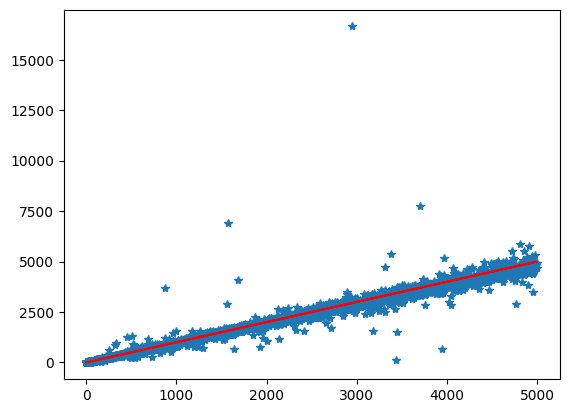

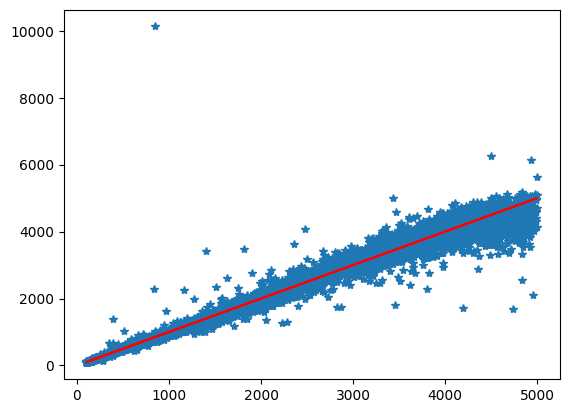

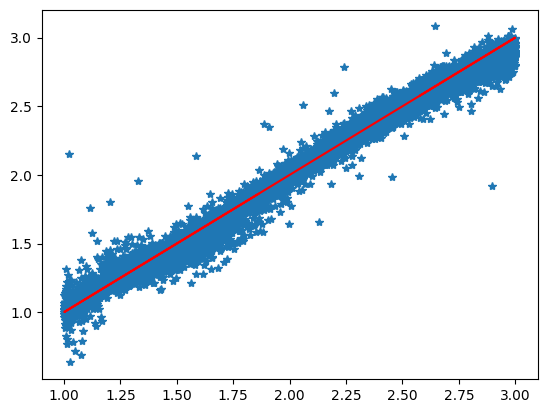

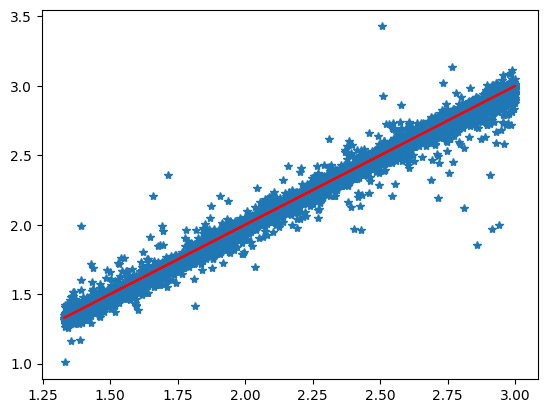

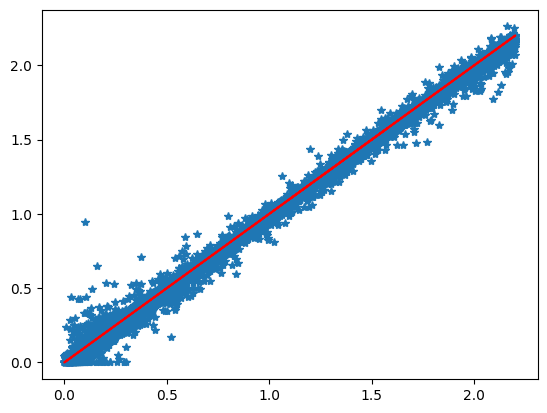

In [89]:

for col in qoi_pred.keys():
    plt.figure()
    plt.plot(qoi_test[col],qoi_pred[col],"*")
    plt.plot(qoi_test[col],qoi_test[col],'r')

In [90]:
# Mean absolute error
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [91]:
for col in qoi_pred.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred[col])
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 30.546476206970524 *** 576.1213120610701 *** 5.302090994983455
RmedianV *** 67.59388575179506 *** 1253.0312610012975 *** 5.394429321562239
GSD *** 0.036180225522624995 *** 1.9964306278191026 *** 1.812245565584626
n *** 0.02469987703244638 *** 2.159699124170475 *** 1.143672132660304
k *** 0.02046698724146558 *** 1.1035239278693876 *** 1.8546935616504403


In [92]:
for col in qoi_pred.keys():
    RMSE = np.sqrt(mean_squared_error(qoi_test[col],qoi_pred[col]))
    col_mean = qoi_test[col].mean()
    col_p = MAE / col_mean *100
    print(col,'***',MAE,'***', col_mean,'***',col_p)

Vtot *** 0.02046698724146558 *** 576.1213120610701 *** 0.0035525481895896317
RmedianV *** 0.02046698724146558 *** 1253.0312610012975 *** 0.001633397974852631
GSD *** 0.02046698724146558 *** 1.9964306278191026 *** 1.0251789847475783
n *** 0.02046698724146558 *** 2.159699124170475 *** 0.9476777117889882
k *** 0.02046698724146558 *** 1.1035239278693876 *** 1.8546935616504403


In [93]:
for col in qoi_pred.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred[col])
    print(col, EVS)

Vtot 0.9800383036398382
RmedianV 0.9832372188423977
GSD 0.9912189314865074
n 0.9938015693553667
k 0.9977217135853015


In [98]:
qoi_pred[qoi_pred['k']==0]

Vtot     RmedianV       GSD         n    k
13       39.932226  1196.988275  1.984602  1.952150  0.0
64     2983.205975   568.788683  0.717574  1.409946  0.0
65       33.275799   560.275177  3.081143  1.435083  0.0
77      542.868499  1331.180338  1.399452  1.448278  0.0
119       2.045208  1264.099837  1.387055  1.554529  0.0
...            ...          ...       ...       ...  ...
17656   942.113265   287.332721  2.484197  1.758990  0.0
17687     2.013335  3116.384423  2.045477  1.861918  0.0
17794    35.747068  1358.399418  1.961811  2.439766  0.0
17799  2172.114912  2931.125580  1.768485  2.373317  0.0
17802    27.880770  2608.403541  2.374291  2.346294  0.0

[359 rows x 5 columns]

In [100]:
qoi_test[qoi_pred['k']==0].sort_values('k')

Vtot     RmedianV       GSD         n         k
4681     21.298213   268.908464  1.060986  1.529695  0.000135
3623   1427.125523   167.760156  1.583093  2.551426  0.000267
14158     8.964300  2284.468416  2.452240  1.639062  0.000346
2259    549.429839  2160.817467  2.158586  1.536239  0.000431
651      11.726409   473.553057  1.016725  1.392919  0.000500
...            ...          ...       ...       ...       ...
17054     6.791234   231.056560  1.133363  2.474525  0.223292
12571     3.272935   395.454768  1.007615  1.659935  0.259015
11522   200.126660   210.535737  1.053906  2.625635  0.291579
12114    51.759543   641.045379  1.002666  2.127240  0.291646
5721      6.181729   328.984807  1.041977  1.694199  0.300315

[359 rows x 5 columns]

# Calculate metrics

In [101]:
qoi_test.columns.values

array(['Vtot', 'RmedianV', 'GSD', 'n', 'k'], dtype=object)

In [102]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
#quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [103]:
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T

In [104]:
r2_adj = pd.DataFrame(r2_adj)
r2_adj

Vtot  RmedianV   GSD     n    k
0  0.98      0.98  0.99  0.99  1.0

In [105]:
r2_adj

Vtot  RmedianV   GSD     n    k
0  0.98      0.98  0.99  0.99  1.0

In [106]:
min(r2_adj.min())

0.98

In [107]:
qoi_test.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     576.121312   1253.031261      1.996431      2.159699      1.103524
std     1047.387832   1267.232900      0.574952      0.483124      0.632293
min        1.000783    100.008814      1.001019      1.330003      0.000135
25%        8.000351    265.658897      1.501265      1.741477      0.554082
50%       67.106629    717.583799      1.992211      2.157726      1.105678
75%      578.605879   1874.496470      2.498469      2.574063      1.649918
max     4998.395477   4999.474451      2.999704      2.999911      2.199874

In [108]:
qoi_pred.describe()

Vtot      RmedianV           GSD             n             k
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000
mean     559.856515   1242.109110      1.985941      2.146372      1.091914
std     1024.438982   1264.208908      0.565054      0.485075      0.629783
min        1.000000     89.762264      0.633372      1.008287      0.000000
25%        7.796907    262.114266      1.482935      1.724745      0.545090
50%       65.425303    694.792227      1.990484      2.144131      1.098186
75%      565.621469   1865.861571      2.489835      2.565512      1.635111
max    16647.097397  10128.709659      3.081143      3.427846      2.261393

In [109]:
qoi_test = qoi_test.reset_index(drop = True)
qoi_test

Vtot     RmedianV       GSD         n         k
0         9.782479   740.955994  1.860629  1.509454  1.576845
1         4.953045   447.099789  1.687354  2.622790  0.754203
2         9.853527  2953.110936  2.635387  2.087974  1.787399
3        27.700011   254.587570  1.044152  2.913697  1.101197
4        49.011526   519.446422  2.185569  2.364048  2.055679
...            ...          ...       ...       ...       ...
17995  2902.889066   244.818462  2.048755  1.459021  0.468698
17996     3.793219   204.348275  1.206468  1.562014  1.081841
17997     8.990683   528.078164  1.949690  2.689447  1.873984
17998  2367.063858   780.091790  2.555797  2.806807  0.538075
17999    84.401659   168.632644  2.579873  2.563342  1.104086

[18000 rows x 5 columns]

In [110]:
error = qoi_pred - qoi_test
error

Vtot   RmedianV       GSD         n         k
0       -0.433576 -15.921212 -0.005239 -0.032423 -0.021713
1       -0.011864   1.061028 -0.005257  0.006366 -0.044906
2       -0.284410 -88.749443 -0.004326 -0.054084 -0.027258
3        1.005626   9.024928  0.067220 -0.033190 -0.060921
4       -1.027265 -22.442898 -0.022966  0.001450 -0.017030
...           ...        ...       ...       ...       ...
17995   65.325647  -1.766069  0.011613 -0.027770  0.003991
17996   -0.065347 -11.500638 -0.005013 -0.040766 -0.018243
17997   -0.306753 -26.755461 -0.030932 -0.022088 -0.001304
17998 -127.707301 -46.073530 -0.051091  0.002409 -0.003553
17999   -0.572726  -0.372080 -0.031961 -0.015538 -0.010871

[18000 rows x 5 columns]

In [111]:
abs_error = np.abs(qoi_test-qoi_pred)
abs_error = pd.DataFrame(abs_error, columns=qoi_test.columns).abs()
abs_error.reset_index(drop=True, inplace=True)
abs_error

Vtot   RmedianV       GSD         n         k
0        0.433576  15.921212  0.005239  0.032423  0.021713
1        0.011864   1.061028  0.005257  0.006366  0.044906
2        0.284410  88.749443  0.004326  0.054084  0.027258
3        1.005626   9.024928  0.067220  0.033190  0.060921
4        1.027265  22.442898  0.022966  0.001450  0.017030
...           ...        ...       ...       ...       ...
17995   65.325647   1.766069  0.011613  0.027770  0.003991
17996    0.065347  11.500638  0.005013  0.040766  0.018243
17997    0.306753  26.755461  0.030932  0.022088  0.001304
17998  127.707301  46.073530  0.051091  0.002409  0.003553
17999    0.572726   0.372080  0.031961  0.015538  0.010871

[18000 rows x 5 columns]

In [112]:
abs_error.mean()

Vtot        30.546476
RmedianV    67.593886
GSD          0.036180
n            0.024700
k            0.020467
dtype: float64

In [113]:
abs_error.mean()

Vtot        30.546476
RmedianV    67.593886
GSD          0.036180
n            0.024700
k            0.020467
dtype: float64

In [115]:
abs_error_table = np.round(abs_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table

Vtot  RmedianV   GSD     n     k
50%    1.79     19.20  0.02  0.02  0.01
75%   17.92     70.29  0.05  0.03  0.03
90%   83.13    183.97  0.08  0.05  0.04
95%  156.52    297.02  0.11  0.06  0.06
99%  358.11    631.80  0.19  0.13  0.12

In [116]:
abs_error_table = np.round(abs_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table

Vtot  RmedianV   GSD     n     k
50%    1.79     19.20  0.02  0.02  0.01
75%   17.92     70.29  0.05  0.03  0.03
90%   83.13    183.97  0.08  0.05  0.04
95%  156.52    297.02  0.11  0.06  0.06
99%  358.11    631.80  0.19  0.13  0.12

In [117]:
rel_error = np.abs(qoi_test - qoi_pred) / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test.columns).abs()
rel_error.reset_index(drop=True, inplace=True)
rel_error

Vtot  RmedianV       GSD         n         k
0      4.432169  2.148739  0.281597  2.147973  1.376960
1      0.239527  0.237314  0.311531  0.242716  5.954053
2      2.886379  3.005286  0.164144  2.590269  1.525029
3      3.630418  3.544921  6.437791  1.139087  5.532225
4      2.095966  4.320541  1.050789  0.061355  0.828430
...         ...       ...       ...       ...       ...
17995  2.250367  0.721379  0.566815  1.903353  0.851429
17996  1.722740  5.627960  0.415548  2.609847  1.686333
17997  3.411897  5.066572  1.586529  0.821279  0.069574
17998  5.395178  5.906168  1.999038  0.085835  0.660353
17999  0.678572  0.220645  1.238876  0.606152  0.984612

[18000 rows x 5 columns]

In [118]:
rel_error.mean()

Vtot        4.556681
RmedianV    4.059565
GSD         1.931247
n           1.192866
k           7.047670
dtype: float64

In [119]:
rel_error.mean()

Vtot        4.556681
RmedianV    4.059565
GSD         1.931247
n           1.192866
k           7.047670
dtype: float64

In [157]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table

Vtot  RmedianV    GSD     n       k
50%   3.24      2.83   1.29  0.85    1.38
75%   5.44      5.30   2.33  1.56    3.06
90%   8.30      8.51   4.01  2.45    9.96
95%  10.97     11.13   5.83  3.16   24.38
99%  26.01     19.65  11.73  6.44  100.00

In [121]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table

Vtot  RmedianV    GSD     n       k
50%   3.24      2.83   1.29  0.85    1.38
75%   5.44      5.30   2.33  1.56    3.06
90%   8.30      8.51   4.01  2.45    9.96
95%  10.97     11.13   5.83  3.16   24.38
99%  26.01     19.65  11.73  6.44  100.00

In [122]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [123]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

Vtot  RmedianV   GSD     n     k
0   5.3      5.39  1.81  1.14  1.85

In [124]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

Vtot  RmedianV   GSD     n     k
0   5.3      5.39  1.81  1.14  1.85

In [125]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [126]:
qoi_test['DmedianV']=qoi_test['RmedianV']*2*1e-3 #[um]
qoi_test['DmedianN']=(np.exp(np.log(qoi_test['DmedianV']) - (3*np.log(qoi_test['GSD'])**2))) *1e3   #[nm]
qoi_test['Ntot'] = 6 / np.pi * (qoi_test['Vtot'])*1e9 / (np.exp((3*np.log(qoi_test['DmedianN'])) + (4.5*np.log(qoi_test['GSD'])**2))) # [cm^-3]
 

In [127]:
qoi_pred['DmedianV']=qoi_pred['RmedianV']*2*1e-3 #[um]
qoi_pred['DmedianN']=(np.exp(np.log(qoi_pred['DmedianV']) - (3*np.log(qoi_pred['GSD'])**2))) *1e3 #[nm] 
qoi_pred['Ntot'] = 6 / np.pi * (qoi_pred['Vtot'])*1e9 / (np.exp((3*np.log(qoi_pred['DmedianN'])) + (4.5*np.log(qoi_pred['GSD'])**2))) # [cm^-3]


In [128]:
D_array = np.logspace(1, 4.5, 200)  # [nm]


In [129]:
presentation_plot_index = [100,2000,3000,4000,5000]

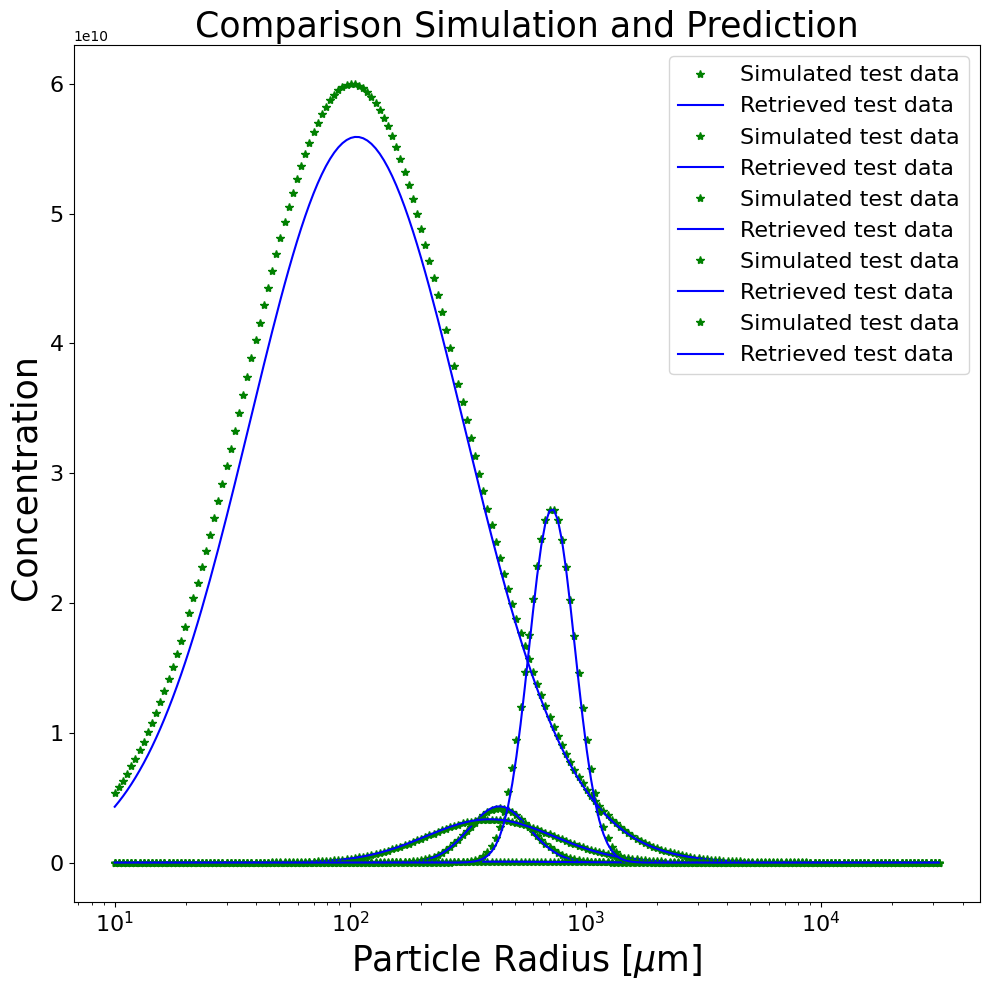

In [130]:
fig, ax = plt.subplots(figsize = (10,10))



for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, qoi_test['DmedianN'].loc[i], qoi_test['GSD'].loc[i], qoi_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, qoi_pred['DmedianN'].loc[i], qoi_pred['GSD'].loc[i], qoi_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*g', label = 'Simulated test data')
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., 'b', label = 'Retrieved test data')
    

    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

In [131]:
## Test testcases

In [132]:
datafile = '/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_16_08_2022/datasetbmtomm_qoi.h5'
qoi_test_1 = pd.read_hdf(datafile,key='qoi1')
qoi_test_2 = pd.read_hdf(datafile,key='qoi2')
qoi_test_cases = pd.read_hdf(datafile,key='qoi')
dvar_test_1 = pd.read_hdf(datafile,key='dvar1')
dvar_test_2 = pd.read_hdf(datafile,key='dvar2')

In [133]:
qoi_test_cases = qoi_test_cases.drop(['F11_5','F11_6','F11_7','F11_8','F11_9','F11_171','F11_172','F11_173','F11_174','F11_175'], axis =1)

In [134]:
qoi_test_cases = qoi_test_cases.drop(['PPF_5','PPF_6','PPF_7','PPF_8','PPF_9','PPF_171','PPF_172','PPF_173','PPF_174','PPF_175'], axis =1)


In [135]:
F11_list = [x for x in qoi_test_cases.columns if 'F11'in x]
PPF_list = [x for x in qoi_test_cases.columns if 'PPF'in x]


In [136]:
qoi_test_cases[F11_list]=qoi_test_cases[F11_list]/4/np.pi *1e12

In [137]:
qoi_test_cases

F11_10        F11_11        F11_12        F11_13        F11_14  \
0   13216.423276  11732.930373  10383.820155   9173.159448   8098.313132   
1   13026.175426  11560.180328  10228.305242   9034.268013   7975.182692   
2   12204.133317  10804.795922   9538.270649   8407.449676   7408.832025   
3   11631.666111  10268.770351   9038.465479   7943.364309   6979.719549   
4   11284.167577   9943.285949   8733.709432   7657.995422   6712.442630   
5   11104.826034   9762.837730   8555.661543   7485.150152   6546.747366   
6   10995.867788   9670.087708   8475.435076   7414.070196   6482.008788   
7   10095.343378   8724.471704   7551.799888   6557.078320   5717.707085   
8    8645.001754   7451.801104   6457.510520   5627.015813   4930.896381   
9    7949.446956   6915.344017   6049.197914   5314.682729   4686.018276   
10   7570.035978   6644.231086   5851.868372   5166.696538   4571.059285   
11   7341.611035   6485.606504   5735.194417   5073.505112   4490.548775   
12   7200.838871   6382.060449   5653.687022   5006.724036   4433.232743   
13  15031.099213  13824.795423  12680.624571  11606.568233  10606.510300   
14   8154.988231   7391.440321   6693.476414   6063.242994   5499.539636   
15   3310.967260   3264.577582   3214.741823   3161.696055   3105.685474   
16   5174.743083   4905.439946   4637.038135   4372.936425   4115.913904   
17   3925.451905   3532.153878   3185.179555   2883.327396   2623.511620   
18   3073.100834   2702.739782   2412.449333   2186.533558   2010.722891   
19   2474.032437   2207.457747   2017.344309   1879.648393   1776.880370   
20   2122.022370   1952.548989   1836.827774   1752.991246   1687.637472   
21   1941.250189   1833.853825   1758.193894   1699.209185   1648.949783   
22   1851.919867   1777.386288   1720.203161   1671.549348   1627.274591   
23   1812.461247   1751.528354   1701.461277   1656.799952   1615.065749   
24   3093.553186   3049.950269   3003.132673   2953.326540   2900.766139   
25   4946.209742   4846.824649   4741.146602   4629.888393   4513.769203   
26   7721.469438   7474.018685   7215.975435   6949.864721   6678.103203   
27  10042.074817   9541.351248   9034.752962   8528.551619   8028.213259   
28   9762.753074   9038.408873   8341.696721   7680.187114   7058.892382   
29   6999.911012   6254.167617   5598.899509   5029.705222   4539.224232   
30   4386.534231   3796.860725   3343.007537   2995.305465   2728.318381   
31   2992.095481   2647.662474   2410.601769   2241.646330   2115.205313   
32   2316.902500   2167.902563   2060.211443   1975.798293   1904.687341   
33   2003.799615   1931.222135   1867.627582   1810.086039   1757.542203   

         F11_15       F11_16       F11_17       F11_18       F11_19  ...  \
0   7152.031508  6324.222160  5603.361187  4977.534059  4435.132858  ...   
1   7043.665858  6229.581625  5521.403020  4907.211194  4375.379575  ...   
2   6534.605351  5774.364389  5116.445369  4548.896653  4060.132620  ...   
3   6139.461950  5411.918552  4785.176843  4247.092212  3785.966493  ...   
4   5889.104519  5177.467385  4565.772174  4041.991752  3594.498896  ...   
5   5731.672047  5028.719846  4425.642862  3910.123803  3470.401043  ...   
6   5671.117769  4970.778599  4369.206310  3854.432698  3414.977347  ...   
7   5011.072695  4416.043604  3913.858752  3488.506644  3126.675083  ...   
8   4344.662029  3848.169946  3425.230864  3063.098722  2751.715774  ...   
9   4145.054246  3678.814169  3277.151133  2930.971645  2631.703524  ...   
10  4052.089756  3600.010187  3206.642946  2864.380636  2566.258538  ...   
11  3979.391585  3534.115924  3148.109758  2813.184301  2521.351562  ...   
12  3927.266246  3484.893305  3101.653804  2770.523563  2482.721526  ...   
13  9681.247770  8829.378328  8048.034929  7333.455534  6681.394917  ...   
14  4998.861594  4556.284675  4166.169819  3822.682561  3520.140739  ...   
15  3046.962193  2985.783059  2922.407534  2857.095665  2790.106161  ...   
16  3868.146754  3631.248595  3406.326600  3194.046546  2

In [138]:
qoi_test_cases[F11_list]=np.log(qoi_test_cases[F11_list])
qoi_test_cases[PPF_list]=10*qoi_test_cases[PPF_list]

In [139]:
dvar_test_cases_scaled = qoi_test_cases.copy()
dvar_test_cases_scaled

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0   9.489216  9.370155  9.248004  9.124037  8.999411  8.875152  8.752142   
1   9.474716  9.355322  9.232914  9.108780  8.984090  8.859884  8.737064   
2   9.409530  9.287745  9.163067  9.036873  8.910428  8.784867  8.661183   
3   9.361486  9.236863  9.109245  8.980092  8.850764  8.722492  8.596359   
4   9.331156  9.204653  9.074945  8.943506  8.811718  8.680859  8.552071   
5   9.315135  9.186338  9.054349  8.920676  8.786724  8.653763  8.522921   
6   9.305275  9.176793  9.044927  8.911135  8.776786  8.643142  8.511332   
7   9.219830  9.073887  8.929541  8.788300  8.651323  8.519405  8.392999   
8   9.064737  8.916211  8.772999  8.635335  8.503276  8.376703  8.255353   
9   8.980858  8.841498  8.707681  8.578229  8.452339  8.329671  8.210346   
10  8.931953  8.801504  8.674516  8.549989  8.427500  8.306988  8.188692   
11  8.901314  8.777341  8.654377  8.531787  8.409730  8.288884  8.170218   
12  8.881953  8.761246  8.640063  8.518537  8.396884  8.275699  8.156193   
13  9.617877  9.534219  9.447830  9.359326  9.269223  9.177946  9.085840   
14  9.006385  8.908078  8.808889  8.710000  8.612420  8.516965  8.424263   
15  8.104996  8.090886  8.075502  8.058864  8.040990  8.021900  8.001617   
16  8.551545  8.498100  8.441831  8.383190  8.322616  8.260531  8.197332   
17  8.275237  8.169663  8.066264  7.966700  7.872269  7.783867  7.701987   
18  8.030442  7.902021  7.788398  7.690073  7.606250  7.535239  7.474897   
19  7.813605  7.699597  7.609537  7.538840  7.482615  7.436529  7.397158   
20  7.660125  7.576891  7.515795  7.469079  7.431085  7.398070  7.367708   
21  7.571087  7.514175  7.472042  7.437918  7.407894  7.379829  7.352577   
22  7.523978  7.482899  7.450198  7.421506  7.394662  7.368590  7.342727   
23  7.502441  7.468244  7.439243  7.412643  7.387131  7.362035  7.336966   
24  8.037076  8.022881  8.007411  7.990687  7.972730  7.953561  7.933204   
25  8.506377  8.486079  8.464034  8.440288  8.414888  8.387883  8.359323   
26  8.951760  8.919188  8.884053  8.846477  8.806589  8.764517  8.720388   
27  9.214539  9.163390  9.108834  9.051175  8.990717  8.927761  8.862600   
28  9.186330  9.109238  9.029022  8.946399  8.862043  8.776577  8.690568   
29  8.853653  8.741003  8.630325  8.523117  8.420511  8.323258  8.231734   
30  8.386295  8.241930  8.114626  8.004801  7.911441  7.832574  7.765765   
31  8.003729  7.881432  7.787632  7.714966  7.656907  7.608525  7.566428   
32  7.747986  7.681515  7.630564  7.588728  7.552073  7.517935  7.484710   
33  7.602800  7.565908  7.532424  7.501130  7.471672  7.443205  7.414286   

      F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0   8.631122  8.512690  8.397313  ...  3.241856  2.969741  2.670248  2.349570   
1   8.616387  8.498461  8.383749  ...  3.017009  2.762333  2.480825  2.178223   
2   8.540215  8.422640  8.308971  ...  1.311272  1.116331  0.903770  0.675239   
3   8.473278  8.353990  8.239056  ... -0.590620 -0.795575 -1.025403 -1.281978   
4   8.426343  8.304493  8.187160  ... -2.019833 -2.274391 -2.547603 -2.834008   
5   8.395171  8.271324  8.152025  ... -2.418628 -2.622361 -2.828263 -3.028518   
6   8.382337  8.256979  8.135926  ... -2.104829 -2.261711 -2.411203 -2.542616   
7   8.272279  8.157229  8.047725  ...  3.655844  3.338552  2.981435  2.597122   
8   8.138924  8.027182  7.919980  ...  3.375726  2.991402  2.550767  2.082434   
9   8.094730  7.983089  7.875387  ...  2.933774  2.559972  2.160330  1.720898   
10  8.072980  7.960107  7.850204  ...  2.677542  2.316663  1.934463  1.537532   
11  8.054557  7.942072  7.832550  ...  2.504320  2.231277  1.914260  1.549329   
12  8.039691  7.926792  7.817111  ...  2.465598  2.154966  1.786169  1.440896   
13  8.993183  8.900202  8.807082  ...  1.605711  1.377069  1.131612  0.873565   
14  8.334752  8.248708  8.166256  ...  2.100299  1.920279  1.720160  1.504061   
15  7.980163  7.957561  7.933835  ...  0.094549  

In [140]:
dvar_test_cases_scaled.columns

Index(['F11_10', 'F11_11', 'F11_12', 'F11_13', 'F11_14', 'F11_15', 'F11_16',
       'F11_17', 'F11_18', 'F11_19',
       ...
       'PPF_161', 'PPF_162', 'PPF_163', 'PPF_164', 'PPF_165', 'PPF_166',
       'PPF_167', 'PPF_168', 'PPF_169', 'PPF_170'],
      dtype='object', length=300)

In [141]:
qoi_pred_cases_scaled = surr.predict(dvar_test_cases_scaled)
qoi_pred_cases_scaled = pd.DataFrame(data=qoi_pred_cases_scaled, columns=dvar_test_1.columns)

In [142]:
qoi_pred_cases_scaled

Vtot  RmedianV       GSD         n         k
0   8.039167  7.005944  1.568012  1.687369  0.000000
1   7.996534  6.987748  1.619146  1.663730  0.000000
2   7.643497  6.868138  1.958425  1.537384  0.000000
3   7.651135  6.722698  1.468180  1.435511  0.000000
4   7.608273  6.650324  1.365278  1.381734  0.000000
5   7.598367  6.502405  1.350987  1.392673  0.000000
6   7.511472  6.340096  1.318293  1.433761  0.000000
7   8.030169  7.184501  1.661031  1.746842  0.000000
8   8.052989  7.331231  1.791740  1.647505  0.000000
9   8.030590  7.389971  1.886552  1.532180  0.000000
10  7.857090  7.318669  1.837074  1.496994  0.000000
11  7.733422  7.224483  1.800486  1.503355  0.000000
12  7.574367  7.154439  1.822126  1.516832  0.000000
13  7.748251  6.369169  1.504997  1.589513  0.000000
14  7.975513  5.467003  3.692968  1.453467  0.014225
15  7.139674  5.054223  1.442279  1.454835  0.017378
16  7.008264  5.719871  2.253996  1.489086  0.053961
17  6.927203  5.621384  2.226505  1.436616  0.079158
18  6.684588  5.347825  1.838379  1.458428  0.110511
19  6.638628  5.249862  1.680113  1.465168  0.081139
20  6.584551  5.159147  1.577719  1.455966  0.065053
21  6.554250  5.119816  1.531182  1.451883  0.050930
22  6.534712  5.102404  1.508889  1.452054  0.043573
23  6.523687  5.094453  1.498215  1.452827  0.039745
24  7.633274  4.919951  1.512470  1.342536  0.000000
25  7.619521  5.130320  1.559216  1.306298  0.011297
26  7.737544  5.338391  1.694011  1.432516  0.022937
27  7.958562  5.903720  2.538804  1.567639  0.040445
28  8.365577  6.014184  3.809059  1.504888  0.000000
29  7.897157  5.258169  3.291418  1.422156  0.061183
30  7.545649  4.910957  3.128065  1.452224  0.175442
31  7.142284  4.941267  2.612751  1.394443  0.046196
32  6.949734  5.095269  1.758346  1.469639  0.061392
33  6.893103  4.985987  1.563482  1.413067  0.046631

In [143]:
qoi_pred_cases=qoi_pred_cases_scaled.copy()

In [144]:
qoi_pred_cases['Vtot'] = np.exp(qoi_pred_cases['Vtot'] )
qoi_pred_cases['RmedianV'] =np.exp(qoi_pred_cases['RmedianV'] )

In [151]:
qoi_pred_cases.loc[34]= [15.616417 ,291.932341,1.387847,1.632377,0.0]

In [152]:
qoi_pred_cases

Vtot     RmedianV       GSD         n         k
0   3100.028778  1103.170944  1.568012  1.687369  0.000000
1   2970.644550  1083.279552  1.619146  1.663730  0.000000
2   2087.028679   961.157298  1.958425  1.537384  0.000000
3   2103.032112   831.056528  1.468180  1.435511  0.000000
4   2014.795378   773.034487  1.365278  1.381734  0.000000
5   1994.936007   666.743224  1.350987  1.392673  0.000000
6   1828.902823   566.850579  1.318293  1.433761  0.000000
7   3072.261178  1318.830683  1.661031  1.746842  0.000000
8   3143.175070  1527.260842  1.791740  1.647505  0.000000
9   3073.553572  1619.659397  1.886552  1.532180  0.000000
10  2583.990042  1508.195811  1.837074  1.496994  0.000000
11  2283.402474  1372.628880  1.800486  1.503355  0.000000
12  1947.626329  1279.774150  1.822126  1.516832  0.000000
13  2317.515748   583.572408  1.504997  1.589513  0.000000
14  2908.850594   236.749495  3.692968  1.453467  0.014225
15  1261.016698   156.682728  1.442279  1.454835  0.017378
16  1105.733351   304.865547  2.253996  1.489086  0.053961
17  1019.638181   276.271434  2.226505  1.436616  0.079158
18   799.981118   210.150761  1.838379  1.458428  0.110511
19   764.045780   190.539993  1.680113  1.465168  0.081139
20   723.825897   174.015957  1.577719  1.455966  0.065053
21   702.222114   167.304559  1.531182  1.451883  0.050930
22   688.635391   164.416643  1.508889  1.452054  0.043573
23   681.084665   163.114567  1.498215  1.452827  0.039745
24  2065.801659   136.995889  1.512470  1.342536  0.000000
25  2037.586894   169.071290  1.559216  1.306298  0.011297
26  2292.835311   208.177425  1.694011  1.432516  0.022937
27  2859.957121   366.398034  2.538804  1.567639  0.040445
28  4296.590297   409.192007  3.809059  1.504888  0.000000
29  2689.624511   192.129458  3.291418  1.422156  0.061183
30  1892.489795   135.769239  3.128065  1.452224  0.175442
31  1264.312914   139.947395  2.612751  1.394443  0.046196
32  1042.871937   163.247758  1.758346  1.469639  0.061392
33   985.454339   146.348010  1.563482  1.413067  0.046631
34    15.616417   291.932341  1.387847  1.632377  0.000000

In [155]:
savedir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_models/forward_model08'

In [156]:
qoi_pred_cases.to_hdf(savedir +'/test_cases.h5',key ='dvar')

In [146]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [147]:
dvar_test_1

Vtot  RmedianV   GSD     n        k
0   1000.0     700.0  1.44  1.34  0.00008
1   1000.0     700.0  1.44  1.34  0.00008
2   1000.0     700.0  1.44  1.34  0.00008
3   1000.0     700.0  1.44  1.34  0.00008
4   1000.0     700.0  1.44  1.34  0.00008
5   1000.0     700.0  1.44  1.34  0.00008
6   1000.0     700.0  1.44  1.34  0.00008
7   1000.0     700.0  1.44  1.34  0.00008
8   1000.0     700.0  1.44  1.34  0.00008
9   1000.0     700.0  1.44  1.34  0.00008
10  1000.0     700.0  1.44  1.34  0.00008
11  1000.0     700.0  1.44  1.34  0.00008
12  1000.0     700.0  1.44  1.34  0.00008
13  1000.0     700.0  1.44  1.34  0.00008
14  1000.0     700.0  1.44  1.34  0.00008
15   600.0     160.0  1.42  1.50  0.07000
16   600.0     160.0  1.42  1.50  0.07000
17   600.0     160.0  1.42  1.50  0.07000
18   600.0     160.0  1.42  1.50  0.07000
19   600.0     160.0  1.42  1.50  0.07000
20   600.0     160.0  1.42  1.50  0.07000
21   600.0     160.0  1.42  1.50  0.07000
22   600.0     160.0  1.42  1.50  0.07000
23   600.0     160.0  1.42  1.50  0.07000
24  1000.0     150.0  1.44  1.34  0.00008
25  1000.0     150.0  1.44  1.34  0.00008
26  1000.0     150.0  1.44  1.34  0.00008
27  1000.0     150.0  1.44  1.34  0.00008
28  1000.0     150.0  1.44  1.34  0.00008
29  1000.0     150.0  1.44  1.34  0.00008
30  1000.0     150.0  1.44  1.34  0.00008
31  1000.0     150.0  1.44  1.34  0.00008
32  1000.0     150.0  1.44  1.34  0.00008
33  1000.0     150.0  1.44  1.34  0.00008

/tmp/ipykernel_84886/4025105096.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1,figsize =(10,6))


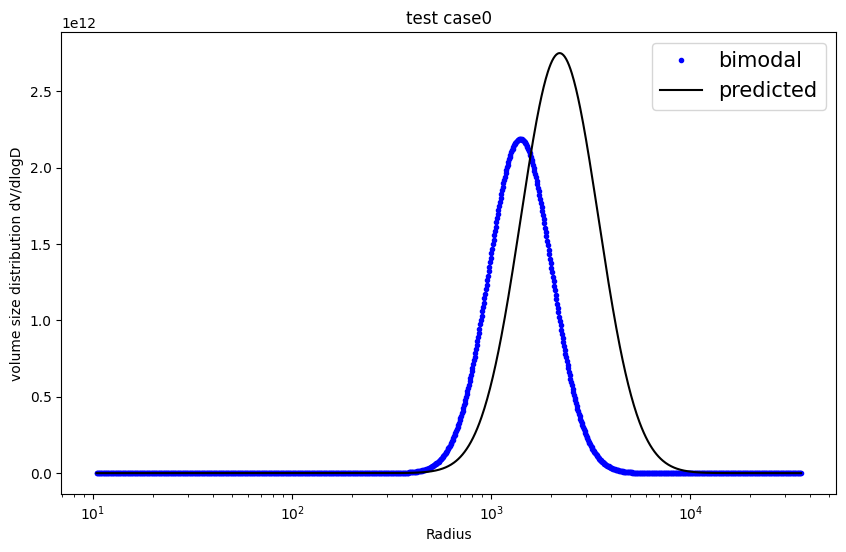

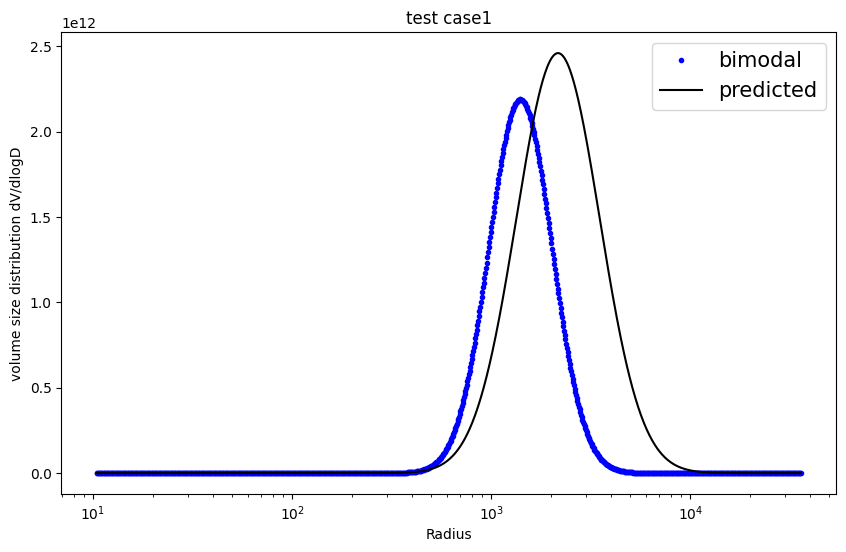

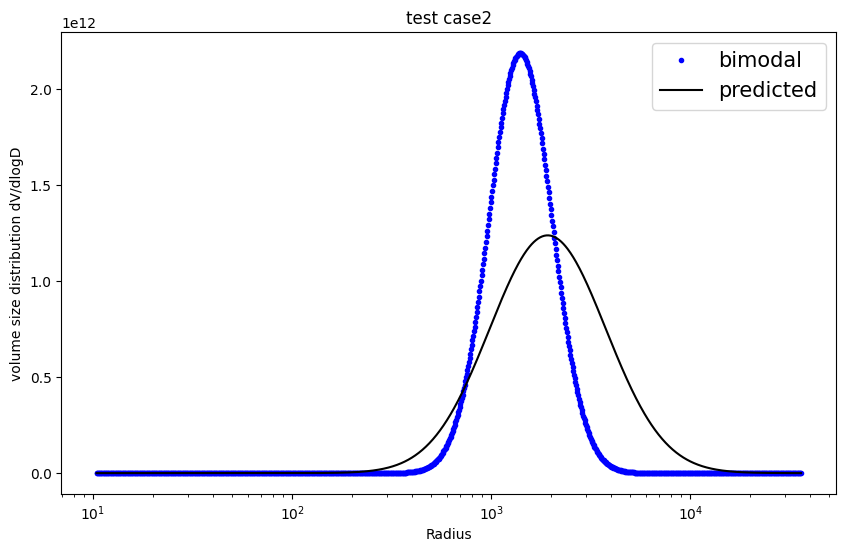

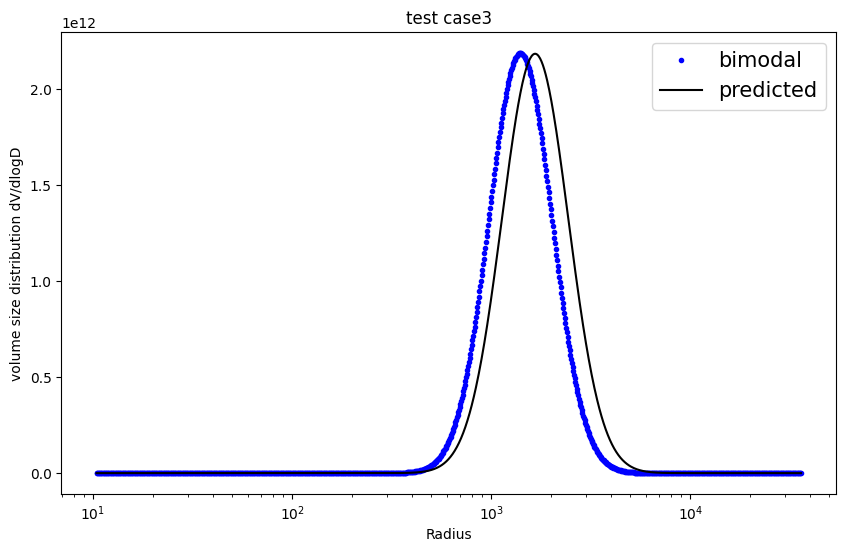

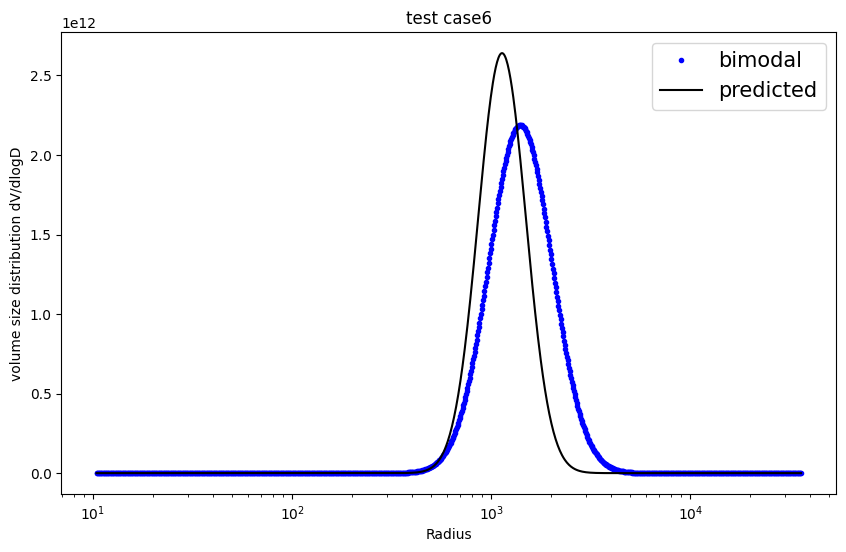

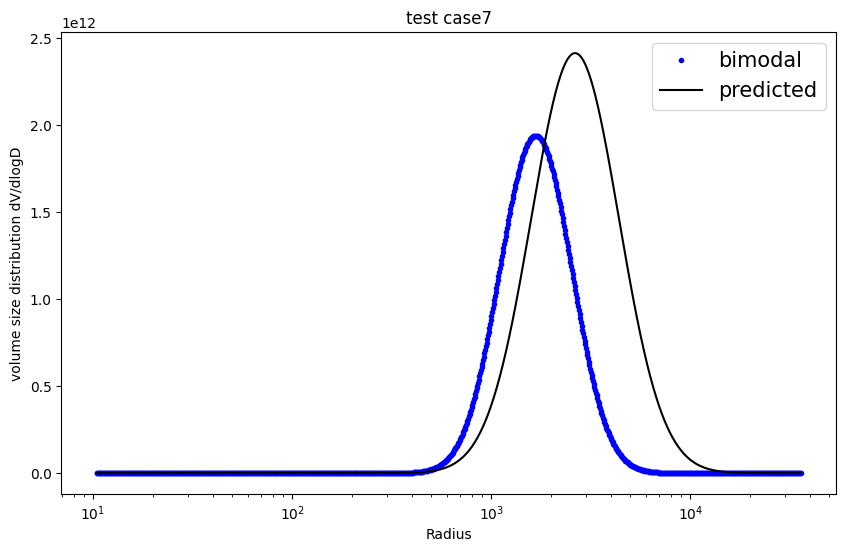

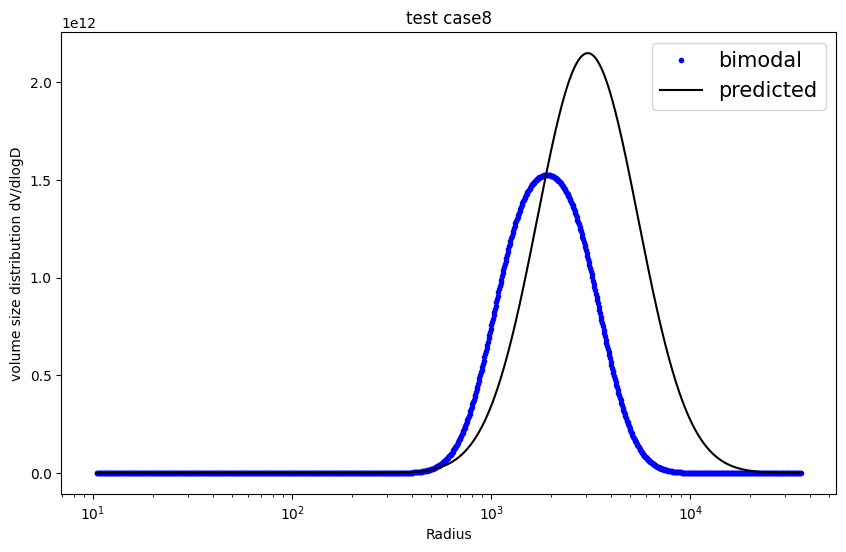

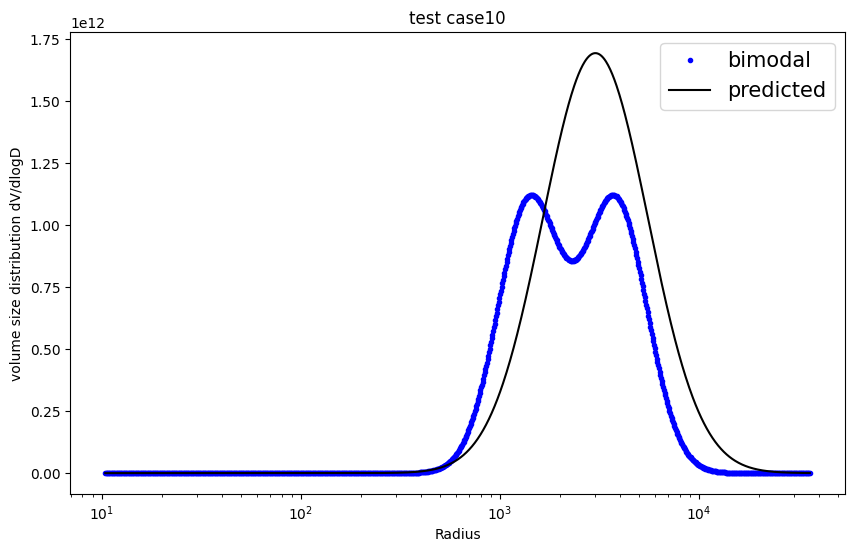

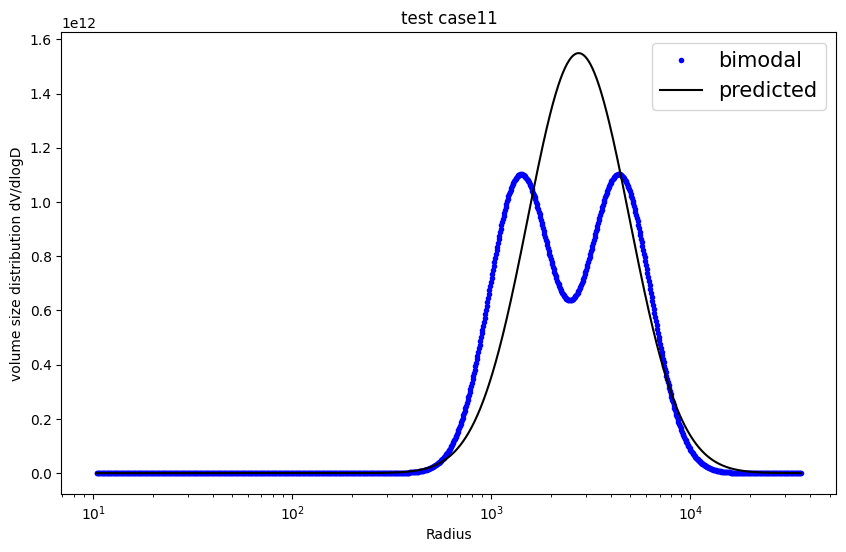

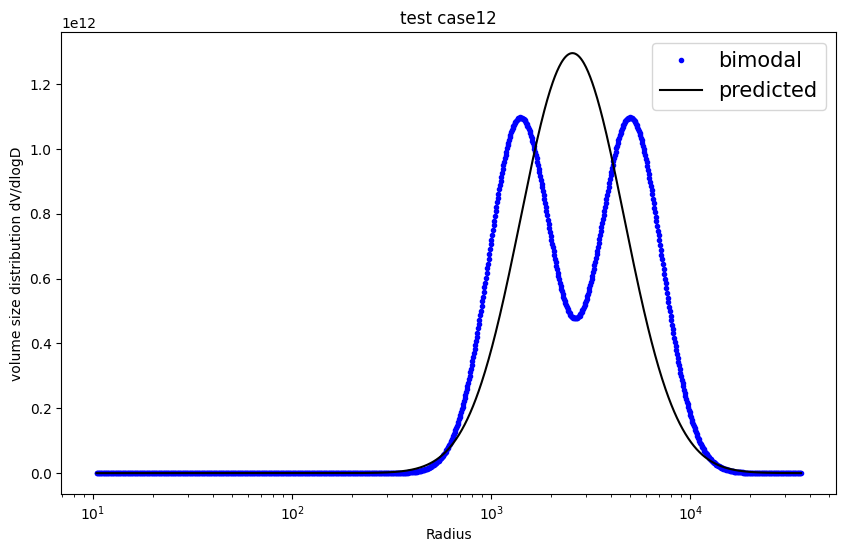

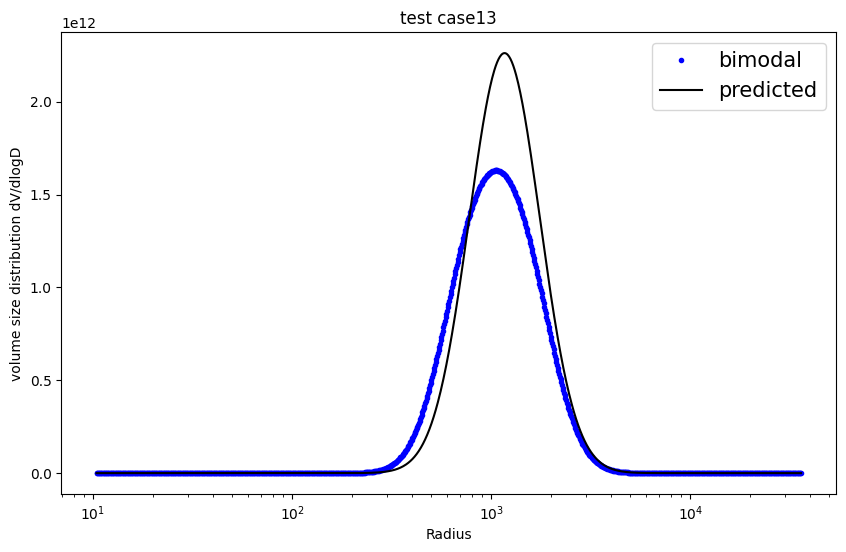

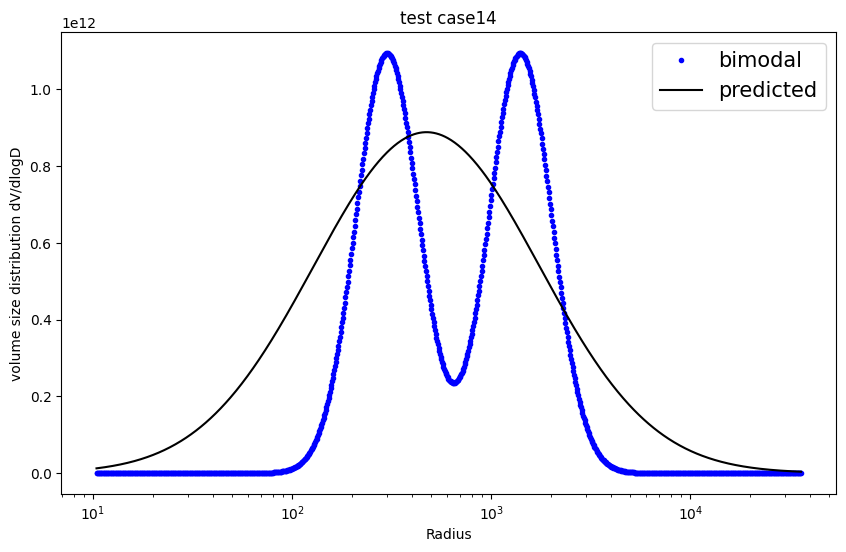

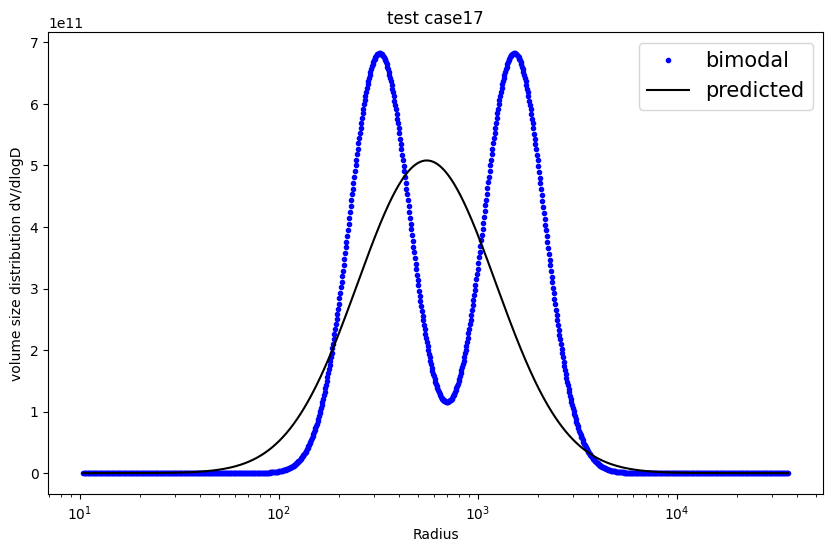

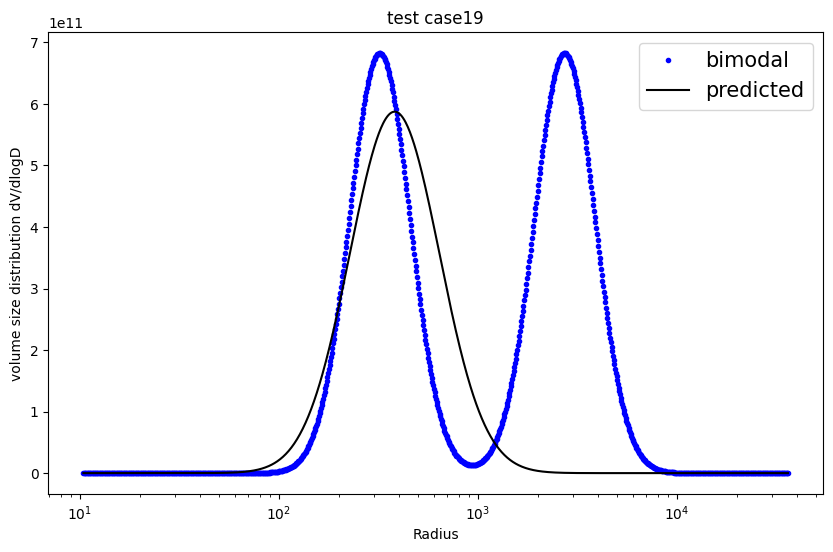

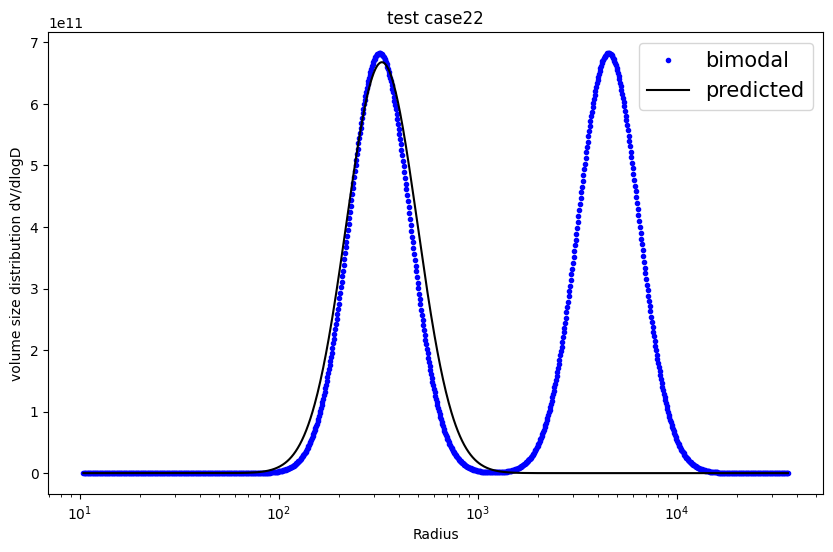

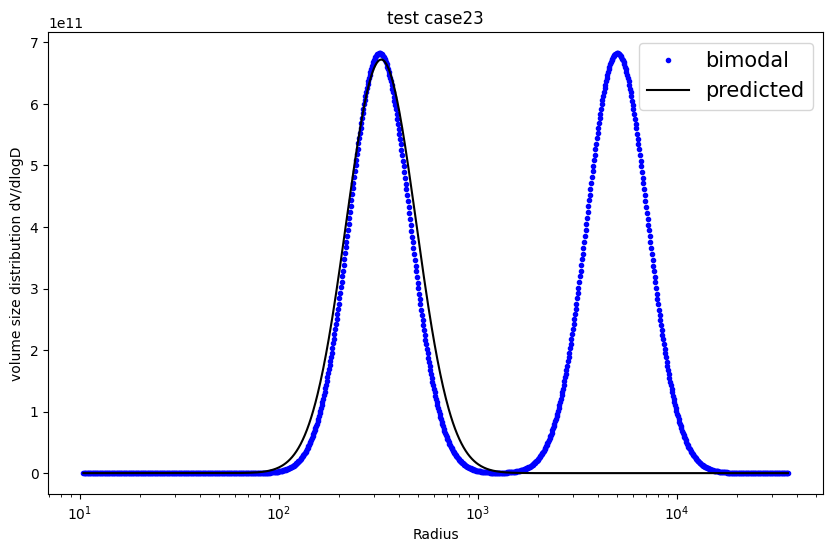

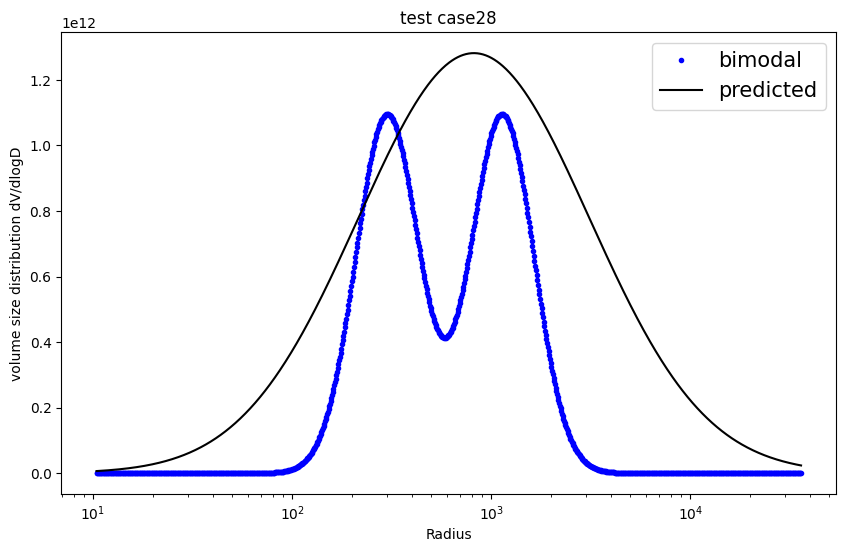

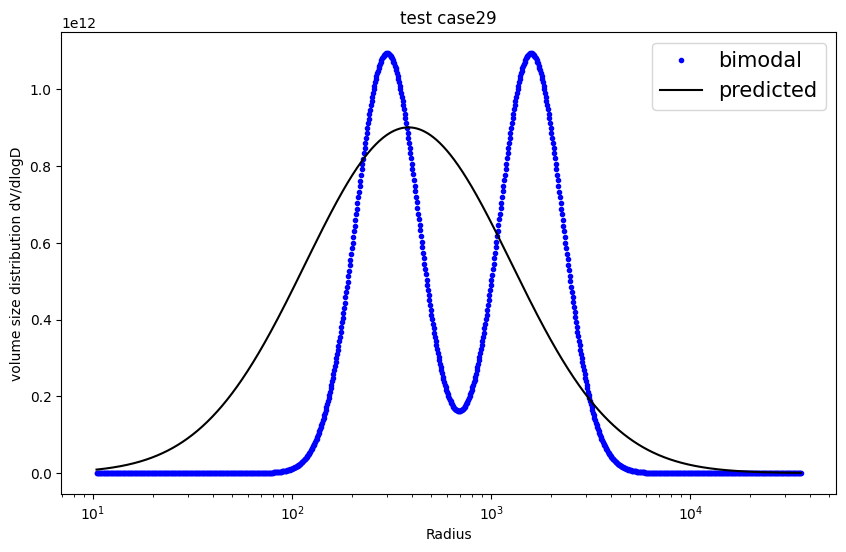

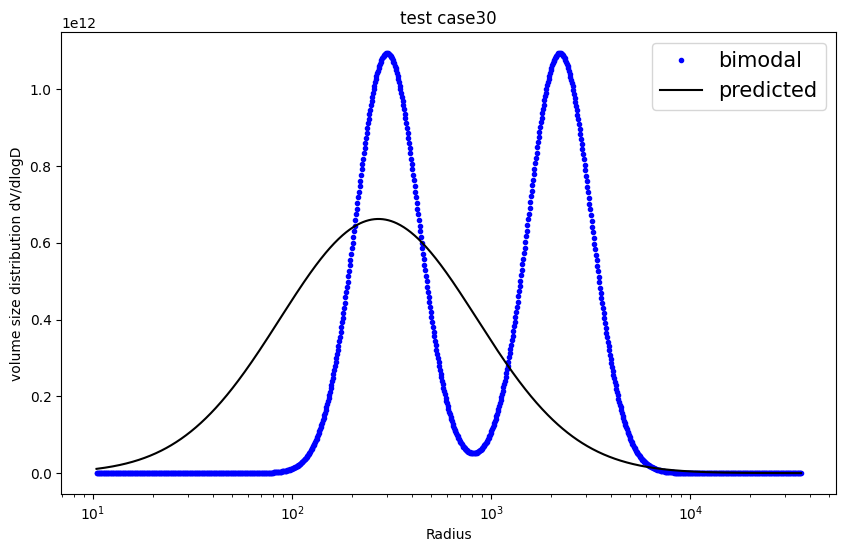

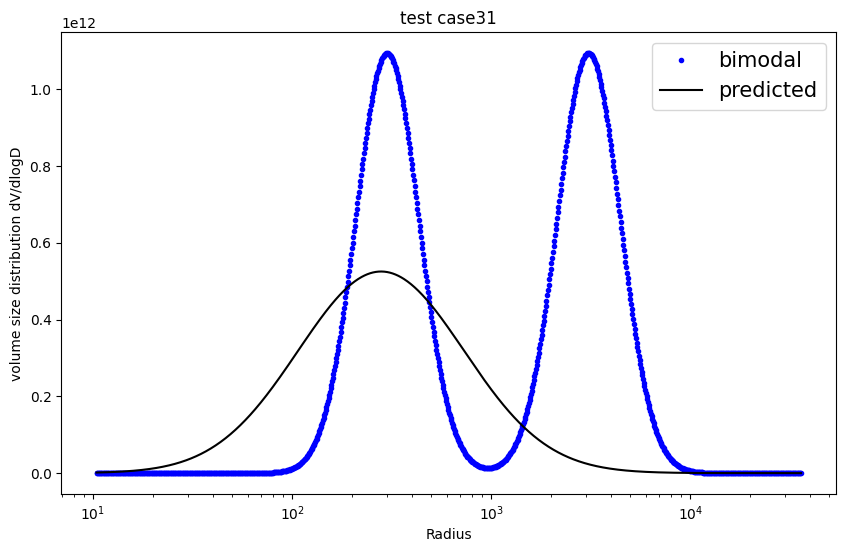

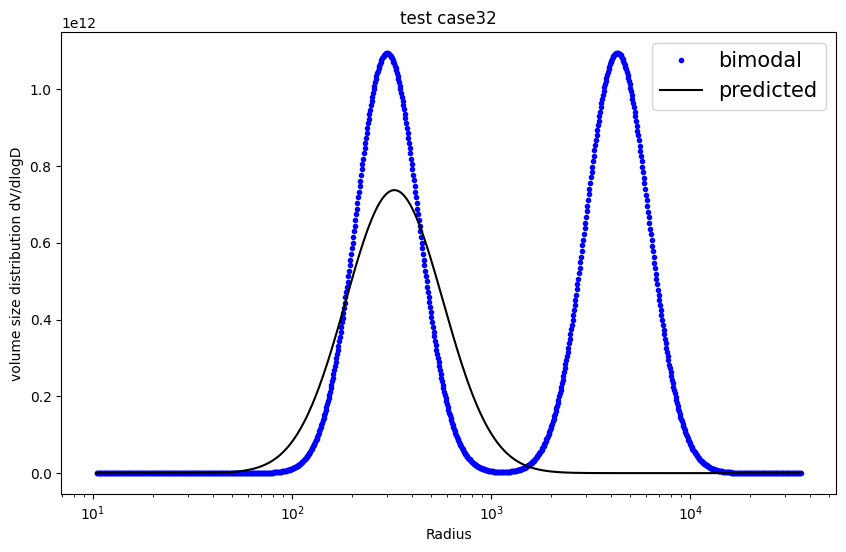

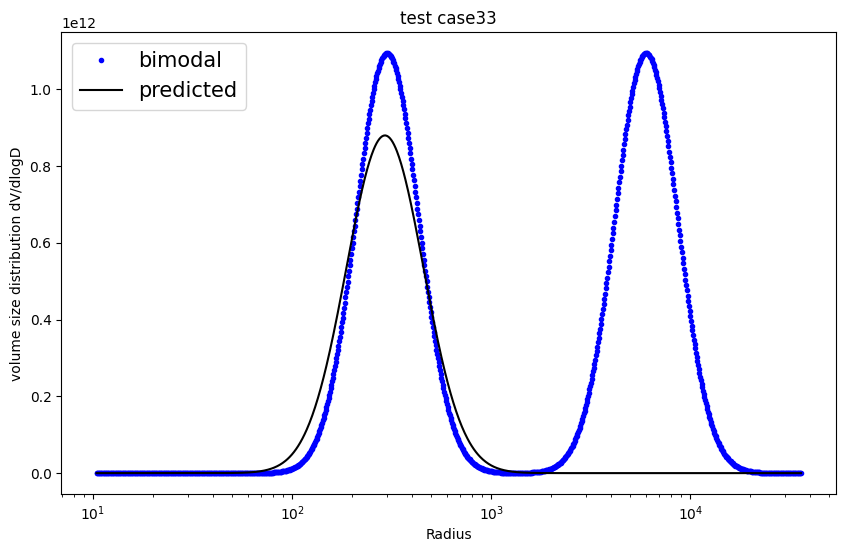

In [148]:
# Computing size distributions for dvar1 and dvar2
D_array = np.logspace(1.0177287669604316, 4.556302500767287, 1000)

for index in dvar_test_1.index:
    V_tot, R_median_V, GSD, ri_n, ri_k = dvar_test_1.loc[index].values

    D_median_V = R_median_V*2  # [nm]
#    print(D_median_V)
    D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(GSD)**2)))      # [nm]
#    print(D_median_N)
  
    N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]

    ndvar_1 = lognormal(D_array, D_median_N , GSD, N_tot) *D_array    
    
    
    V_tot, R_median_V, GSD, ri_n, ri_k = dvar_test_2.loc[index].values

    D_median_V = R_median_V*2  # [nm]
    #print(D_median_V)
    D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(GSD)**2)))      # [nm]
    #print(D_median_N)
  
    N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]
    #print
    ndvar_2 = lognormal(D_array, D_median_N , GSD, N_tot) *D_array
    
    V_tot, R_median_V, GSD, ri_n, ri_k = qoi_pred_cases.loc[index].values
    #V_tot = np.exp(V_tot)
    #R_median_V = np.exp(R_median_V)
    D_median_V = R_median_V*2  # [nm]
#    print(D_median_V)
    D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(GSD)**2)))      # [nm]
#    print(D_median_N)
  
    N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]

    ndvar_pred= lognormal(D_array, D_median_N , GSD, N_tot) *D_array
    
    fs = 15
    fig,ax=plt.subplots(1,1,figsize =(10,6))
    ax.plot(D_array,ndvar_1*4/3*np.pi*(D_array/2.)**3.+ndvar_2*4/3*np.pi*(D_array/2.)**3. ,'b.',label = 'bimodal')
    ax.plot(D_array,ndvar_pred*4/3*np.pi*(D_array/2.)**3.,'k',label = 'predicted')
    ax.set_xscale('log')
    ax.legend(fontsize = fs)
    ax.set_xlabel('Radius')
    ax.set_ylabel('volume size distribution dV/dlogD')
    ax.set_title('test case'+str(index))
#plt.title('$V_{tot}=$ %.1f$\mu m^3 cm^{-3}$, $D=$ %.2f$\mu m$, GSD=%.4f \n m= %.4f -i %.5f' %
#             (parameters1['Vtot'].loc[index], parameters1['RmedianV'].iloc[index]*2*1e-3,
#              parameters1['GSD'].loc[index], parameters1['n'].iloc[index], parameters1['k'].iloc[index]))

# Save $\bar{R}^2$

In [ ]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

In [ ]:
r2_adj_T = r2_adj.T
r2_adj_T=r2_adj_T.rename(columns={0: "r2_adj"})
r2_adj_T

# Plot

In [ ]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_model_r2_adj.jpg')


## Relative Errors

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles.jpg')

## DVARs vs. percentage errors

In [ ]:
def plot_error_vs_dvar(design_var):
    fig, axes = plt.subplots(4, 3, figsize=(16, 27))


    for i, col in enumerate(qoi_test.columns[0:12]):
        ax = axes.flatten()[i]

        ax.plot(dvar_test[design_var],
                rel_error[col],
                'o');

        ax.hlines(y=0.,
                  xmin=dvar_test[design_var].min(),
                  xmax=dvar_test[design_var].max(),
                  color='red',
                  zorder=3)

        ax.set_xlabel(design_var, fontsize=20)
        ax.set_ylabel(r'$\Delta$' + col + r' [%]', fontsize=20)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/percentage_error_vs_{design_var}.jpg')
    
    return fig

In [ ]:
qoi_test.columns[0:11]

In [ ]:
qoi_pred[qoi_pred['Vtot']<0]

In [ ]:
for d in dvar_test.columns:
    plot_error_vs_dvar(d)

## Correlations between DVARs and QOIs

In [ ]:
combined = pd.concat([dvar_test, rel_error], axis=1)

In [ ]:
corr = np.round(combined.corr(), decimals=2)

In [ ]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [ ]:
qoi_test.columns

In [ ]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [ ]:
to_plot

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

In [ ]:
error


In [ ]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi_test.columns[0:3]:
    sns.distplot(error[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[0],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[1],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[2],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [ ]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [ ]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

In [ ]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(error[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [ ]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [ ]:
rel_error.abs().quantile(0.9)

In [ ]:
qoi_columns = qoi_test.columns

In [ ]:
statistic, p = scipy.stats.shapiro(standardise(error[qoi_test.columns[0]]).values)

In [ ]:
statistic

In [ ]:
p

In [ ]:
surr.model.summary()

In [ ]:
qoi_pred

In [ ]:
test_index = qoi_test.index.tolist()
test_index

In [ ]:
presentation_plot_index = [0,1,3,4,5,6]

qoi_test.index.values

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    ax.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result_all.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    plot_test_data = ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = ax.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
ax.legend(['Test data', 'Predicted test data'], fontsize = 16)
#ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
    
    #plt.yscale('logit')
    
    
ax.set_xlabel('Test data',fontsize = 25)
ax.set_ylabel('Predicted test data ',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

ax.axline([-25, -25], [-8, -8])


#fig.align_labels()
#ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data_correlation.jpg')

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_dir

In [ ]:
plot_model(surr.model, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(pd.DataFrame(r2_adj_T, columns = ['r2_adj']).T,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_forward_model.jpg')
